In [ ]:
!pip install transformers
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall numba
!pip install umap-learn
!pip install -U numba
!pip install -e git+https://github.com/lmcinnes/umap.git@0.4dev#egg=umap4
!pip install /content/src/umap4

Found existing installation: numba 0.57.0
Uninstalling numba-0.57.0:
  Would remove:
    /usr/local/bin/numba
    /usr/local/lib/python3.10/dist-packages/numba-0.57.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numba/*
Proceed (Y/n)? Y
  Successfully uninstalled numba-0.57.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numba-0.57.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch
from transformers import HerbertTokenizer, RobertaModel, AutoTokenizer, BertModel

import umap
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [ ]:
def get_data_set(labels, df):
  idxs = []
  for label in labels:
    idxs_for_label, = np.where(df['Label'] == label)
    for idx in idxs_for_label:
      idxs.append(idx)

  new_df = df.iloc[idxs]
  new_df = new_df.sample(frac = 1).reset_index(drop=True)
  return new_df

In [ ]:
def print_classes(df):
  y = df["Label"]
  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]
  authors = {}
  num_classes = len(df['Label'].unique())
  for label in range(0, num_classes):
    i, = np.where(y == label)
    authors['{}'.format(df['Author-short'][i[0]])] = label

  return authors

In [ ]:
def make_tokens(df, model):
  model_name, tokenizer, model = model
  tokens = {}

  df_tokens = pd.DataFrame()
  tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
  df_tokens['tokens'] = df['Text'].map(tokenize)
  df_tokens['input_ids'] = df_tokens['tokens'].map(lambda t: t['input_ids'] )
  df_tokens['token_type_ids'] = df_tokens['tokens'].map(lambda t: t['token_type_ids'] )
  df_tokens['attention_mask'] = df_tokens['tokens'].map(lambda t: t['attention_mask'] )


  input_ids = np.stack(df_tokens['input_ids'])
  token_type_ids = np.stack(df_tokens['token_type_ids'])
  attention_mask = np.stack(df_tokens['attention_mask'])

  inputs = {"input_ids":torch.tensor(input_ids),"token_type_ids":torch.tensor(token_type_ids),"attention_mask":torch.tensor(attention_mask)}

  return df_tokens, inputs


In [ ]:
df_tokens, inputs = make_tokens(df_raw, herbert)

In [ ]:
outputs = model(**inputs)

In [ ]:
#dzielenie tokenów na 9 porcji
X_stack = []
embedded = {}
model_name, tokenizer, model = herbert

for idx in tqdm(range(0,400)):
  x = 0

  for i in range(0,9):

    y = x+100
    if(i>7):
      y = 512

    input_ids = np.stack(df_tokens["input_ids"].iloc[idx:idx+1])
    token_type_ids = np.stack(df_tokens["token_type_ids"].iloc[idx:idx+1])
    attention_mask = np.stack(df_tokens["attention_mask"].loc[idx:idx+1])

    input_ids = np.array([input_ids[0][x:y]])
    token_type_ids = np.array([token_type_ids[0][x:y]])
    attention_mask = np.array([attention_mask[0][x:y]])

    x = x + 60

    inputs = {"input_ids":torch.tensor(input_ids),"token_type_ids":torch.tensor(token_type_ids),"attention_mask":torch.tensor(attention_mask)}

    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])
    embedded[idx,i] = X_single_poem[0], df_raw['Label'][idx]


  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['{}_embedding'.format(model_name), 'label'])



In [ ]:
def make_embedding(df, model):

  X_stack = []
  model_name, tokenizer, model = model
  embedded = {}
  tokens = {}
  num_idxs = df.shape[0]
  for idx in tqdm(range(0,num_idxs)):
    single_poem_input = df['Text'][idx]
    inputs = tokenizer.batch_encode_plus([single_poem_input], max_length = 512, padding="longest", add_special_tokens=True, return_tensors="pt",)
    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])

    embedded[idx] = X_single_poem[0], df['Label'][idx]

  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['{}_embedding'.format(model_name), 'label'])

  return df_embedded

In [ ]:
def get_X_y(df):

  X = np.stack(df['Herbert_embedding'])
  y = df['Label']

  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

  print(X.shape)

  return X, y, X_train, X_test, y_train, y_test,  X_val, y_val

In [ ]:
def normalize_data(X):

  X_normalized = np.zeros((X.shape[0],X.shape[1]))

  for idx in range(0,X.shape[0]):
    X_normalized[idx,:] = (X[idx,:] - np.mean(X[idx,:]))/ np.std(X[idx,:])

  return X_normalized

In [ ]:
herbert = ["Herbert", HerbertTokenizer.from_pretrained("allegro/herbert-large-cased"), RobertaModel.from_pretrained("allegro/herbert-large-cased")]
#bert = ["Bert", AutoTokenizer.from_pretrained("bert-base-uncased"), BertModel.from_pretrained("bert-base-uncased")]

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing RobertaModel: ['bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.17.output.LayerNorm.bias', 'bert.encoder.layer.13.output.LayerNorm.bias', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.encoder.layer.13.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.15.output.dense.bias', 'bert.encoder.layer.11.attention.self.value.weight', 'bert.encoder.layer.18.attention.self.value.weight', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.16.output.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.15.attention.self.key.weight', 'bert.encoder.layer.12.attention.output.dense.bias', 'bert.encoder.layer.15.attention.output.LayerN

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/wiersze_do_BERT_light.csv', ";")
df_raw .columns

<ipython-input-10-58702acb4ffc>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_raw = pd.read_csv('/content/drive/MyDrive/wiersze_do_BERT_light.csv', ";")


Index(['Author', 'Author-short', 'Title', 'Text', 'From', 'Note', 'Words',
       'Label', 'Gender', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [ ]:
df_raw  = df_raw .drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'])
df_raw.shape

(400, 9)

In [ ]:
df_orginal = pd.DataFrame
df_orginal = pd.concat([df_raw['Text'],df_raw['Label'],df_raw['Author-short']], axis=1)

In [ ]:
df_orginal

,Text,Label,Author-short
0,W tej porze zmierzchu woda i światło tworzą po...,0,K. K. Baczyński
1,Smutek jakże ogromny. Zmierzch duszny dławi. D...,0,K. K. Baczyński
2,Deszczu srebrne gałązki rosną jak gotyckich kr...,0,K. K. Baczyński
3,"Nie to, co mi się śniło, ale com krwią przepła...",0,K. K. Baczyński
4,Których nam nikt nie wynagrodzi i których nic ...,0,K. K. Baczyński
...,...,...,...
395,Wielki Odkrywco Wyobraźni na rybiookich wspart...,7,E. Lipska
396,Odchodzisz ode mnie jak lato. I powracasz do m...,7,E. Lipska
397,I jak tu popełnić samobójstwo droga pani kiedy...,7,E. Lipska
398,W oczy mi patrzysz wciąż tak samo jak w tysiąc...,7,E. Lipska


In [ ]:
df_women = df_raw[200:].reset_index(drop=True)
df_men = df_raw[:200].reset_index(drop=True)
#df_women = df_women.sample(frac = 1).reset_index(drop=True)
#df_men = df_men.sample(frac = 1).reset_index(drop=True)

In [ ]:
embedding = make_embedding(df_men, herbert)

100%|██████████| 200/200 [05:33<00:00,  1.67s/it]


In [ ]:
df_men = pd.concat([df_men, embedding['Herbert_embedding']], axis=1)
df_men

,Author,Author-short,Title,Text,From,Note,Words,Label,Gender,Herbert_embedding
0,Krzysztof Kamil Baczyński,K. K. Baczyński,Oddech wiosenny,W tej porze zmierzchu woda i światło tworzą po...,NaN,NaN,236,0,0,"[0.36175004, -0.664724, -1.0099914, 0.8409236,..."
1,Krzysztof Kamil Baczyński,K. K. Baczyński,Święto umarłych,Smutek jakże ogromny. Zmierzch duszny dławi. D...,NaN,NaN,250,0,0,"[0.3961806, -0.543601, -0.9002346, 0.8073483, ..."
2,Krzysztof Kamil Baczyński,K. K. Baczyński,Westchnienie,Deszczu srebrne gałązki rosną jak gotyckich kr...,NaN,NaN,101,0,0,"[0.2932581, -0.44927713, -0.96263075, 1.009855..."
3,Krzysztof Kamil Baczyński,K. K. Baczyński,"***(Nie to, co mi się śniło…)","Nie to, co mi się śniło, ale com krwią przepła...",NaN,NaN,246,0,0,"[0.49269202, -0.48862532, -0.8141572, 0.884061..."
4,Krzysztof Kamil Baczyński,K. K. Baczyński,***(Których nam nikt nie wynagrodzi…),Których nam nikt nie wynagrodzi i których nic ...,NaN,NaN,128,0,0,"[0.36619845, -0.72556305, -0.90282106, 0.93380..."
...,...,...,...,...,...,...,...,...,...,...
195,Czesław Miłosz,Cz. Miłosz,Wiersz na koniec stulecia,Kiedy już bylo dobrze I znikło pojęcie grzechu...,NaN,NaN,234,3,0,"[0.34102574, -0.71655375, -0.81055343, 0.96808..."
196,Czesław Miłosz,Cz. Miłosz,Zanurzeni,Ależ nie każdemu zdarza się prawdziwa starość....,NaN,NaN,118,3,0,"[0.33440992, -0.49460992, -1.0164859, 0.822354..."
197,Czesław Miłosz,Cz. Miłosz,Ze szkodą,Jak najmniej szkodzić. O to zabiegałem. Choć m...,NaN,NaN,118,3,0,"[0.40463087, -0.5114168, -1.0463587, 0.9113997..."
198,Czesław Miłosz,Cz. Miłosz,Daemones,Zbliża się pora wyznania. Oto się prawda odsła...,NaN,NaN,250,3,0,"[0.46756092, -0.5496135, -0.82522905, 0.980217..."


In [ ]:
classes = print_classes(df_men)
classes

{'K. K. Baczyński': 0, 'A. Mickiewicz': 1, 'J. Kochanowki': 2, 'Cz. Miłosz': 3}

In [ ]:
X, y, _,_,_,_,_,_ = get_X_y(df_men)

(200, 1024)


In [ ]:
X_norm = normalize_data(X)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

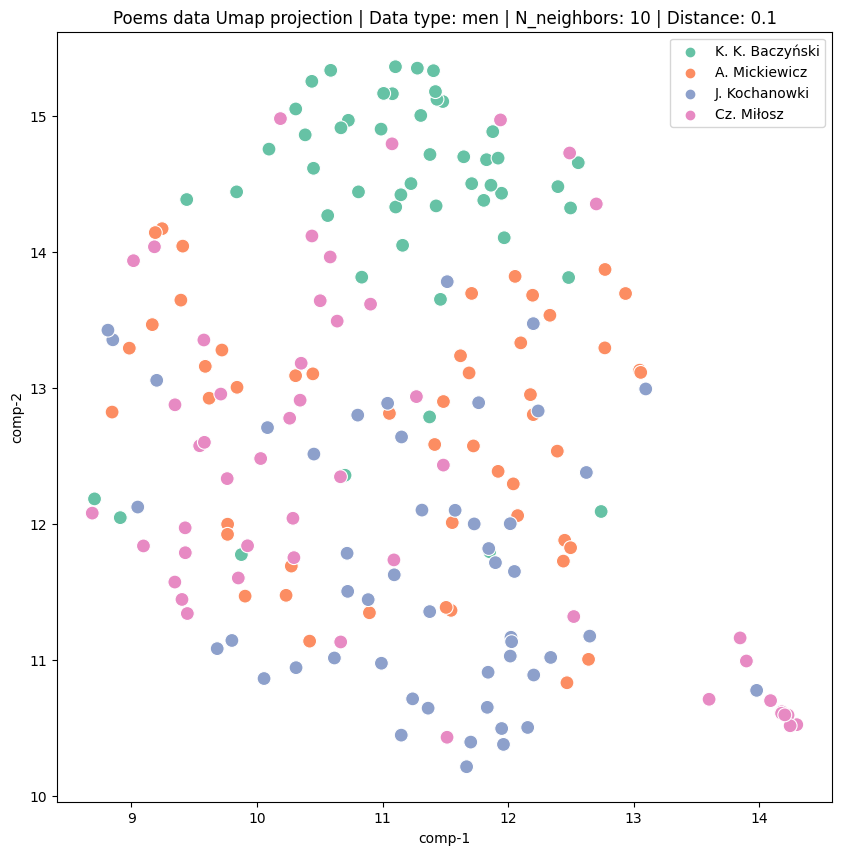

In [ ]:
# Umap
df_umap = pd.DataFrame()
df_umap["y"] = df_men['Author-short']
data_type = 'men'
num_classes = len(classes)
n_neighbors = [10]
min_distnces= [0.1]
n_components=2
metric='euclidean'

for n_neighbor in n_neighbors:
  for min_dist in min_distnces:
    reducer = umap.UMAP(n_neighbors=n_neighbor,
            min_dist=min_dist,
            n_components=n_components,
            metric=metric)
    scaled_X = StandardScaler().fit_transform(X_norm)
    embed = reducer.fit_transform(scaled_X)

    df_umap["comp-1"] = embed[:,0]
    df_umap["comp-2"] = embed[:,1]

    plt.figure(figsize = (10,10))
    sns.scatterplot(x="comp-1", y="comp-2", hue=df_umap.y.tolist(),
                   palette=sns.color_palette("Set2", num_classes),
                   data=df_umap, s=100).set(title="Poems data Umap projection | Data type: {} | N_neighbors: {} | Distance: {}".format(data_type, n_neighbor, min_dist))


plt.savefig('/content/figs/umap_{}.png'.format(data_type))
files.download('/content/figs/umap_{}.png'.format(data_type))

In [ ]:
# 3D PCA
data_type = 'men'
scaler = StandardScaler()
scaler.fit(X_norm)
scaled_X = scaler.transform(X_norm)
pca = PCA(n_components=3)
pca.fit(scaled_X)
pca_X = pca.transform(scaled_X)

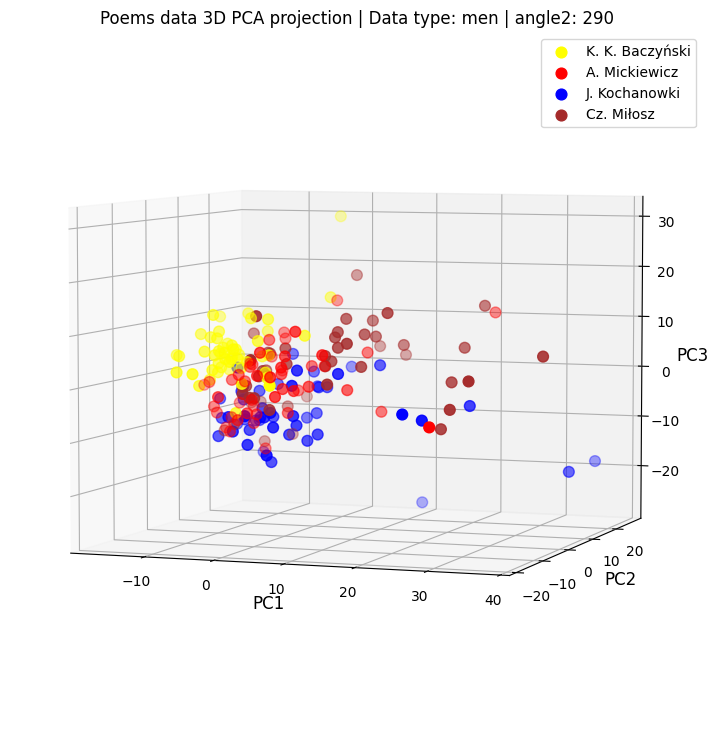

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
angle1 = 5

angles = [290]# np.arange(100,175,5)
for angle2 in angles:
  Xax = pca_X[:,0]
  Yax = pca_X[:,1]
  Zax = pca_X[:,2]

#cdict = {0:'cyan',1:'violet',2:'orange',3:'green',4:'yellow',5:'red',6:'blue',7:'brown'}
#label = {0:'K. K. Baczyński',1:'A. Mickiewicz',2:'J. Kochanowki',3:'Cz. Miłosz',4:'W. Szymborska',5:'H. Poświatowska',6:'M. P. Jasnorzewska',7:'E. Lipska'}
  label = {0:'K. K. Baczyński',1:'A. Mickiewicz',2:'J. Kochanowki',3:'Cz. Miłosz'}
  cdict = {0:'yellow',1:'red',2:'blue',3:'brown'}

  fig = plt.figure(figsize=(14,9))
  ax = fig.add_subplot(111,
                     projection='3d')

  for l in np.unique(y):
    ix=np.where(y==l)
    ax.scatter(Xax[ix],
              Yax[ix],
              Zax[ix],
              c=cdict[l],
              s=60,
            label=label[l])

  ax.set_xlabel("PC1",
                fontsize=12)
  ax.set_ylabel("PC2",
                fontsize=12)
  ax.set_zlabel("PC3",
                fontsize=12)

  ax.view_init(angle1, angle2)
  ax.legend()
  plt.title("Poems data 3D PCA projection | Data type: {} | angle2: {}".format(data_type, angle2))
  plt.show()

plt.savefig('/content/figs/pca_3D_{}.png'.format(data_type))
files.download('/content/figs/pca_3D_{}.png'.format(data_type))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

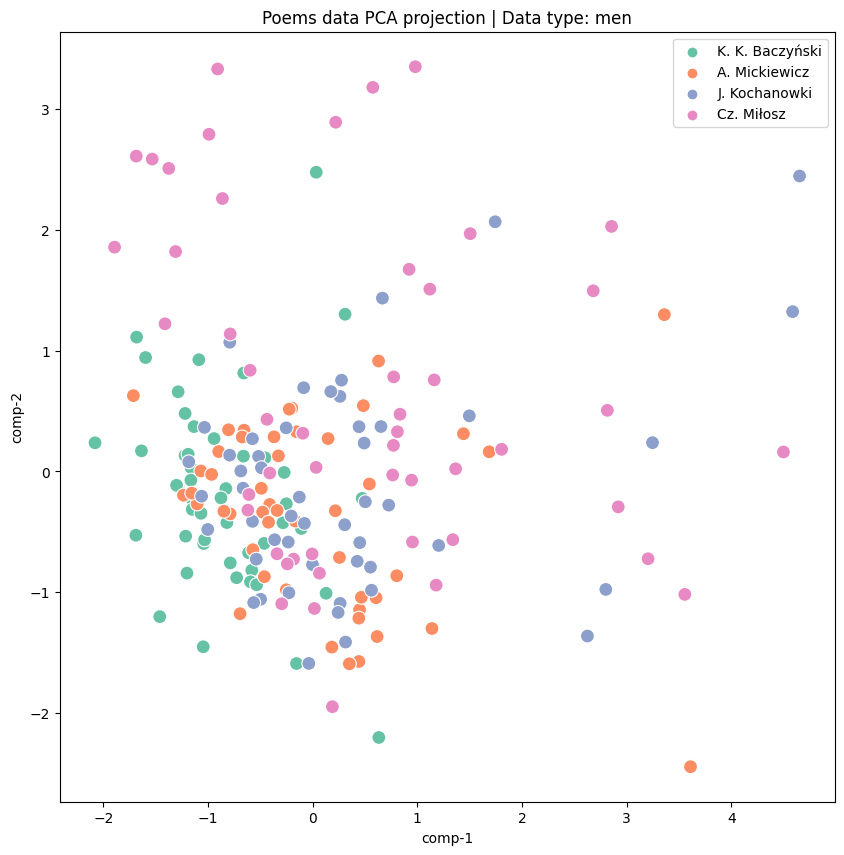

In [ ]:
df_pca = pd.DataFrame()
df_pca["y"] = df_men['Author-short']
data_type = 'men'
num_classes = len(classes)

plt.figure(figsize = (10,10))
pca = PCA(n_components=2).fit_transform(X_norm, y)

df_pca["comp-1"] = pca[:,0]
df_pca["comp-2"] = pca[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_pca.y.tolist(),
                palette=sns.color_palette("Set2", num_classes),
                data=df_pca, s=100).set(title="Poems data PCA projection | Data type: {}".format(data_type))

plt.savefig('/content/figs/pca_{}.png'.format(data_type))
files.download('/content/figs/pca_{}.png'.format(data_type))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

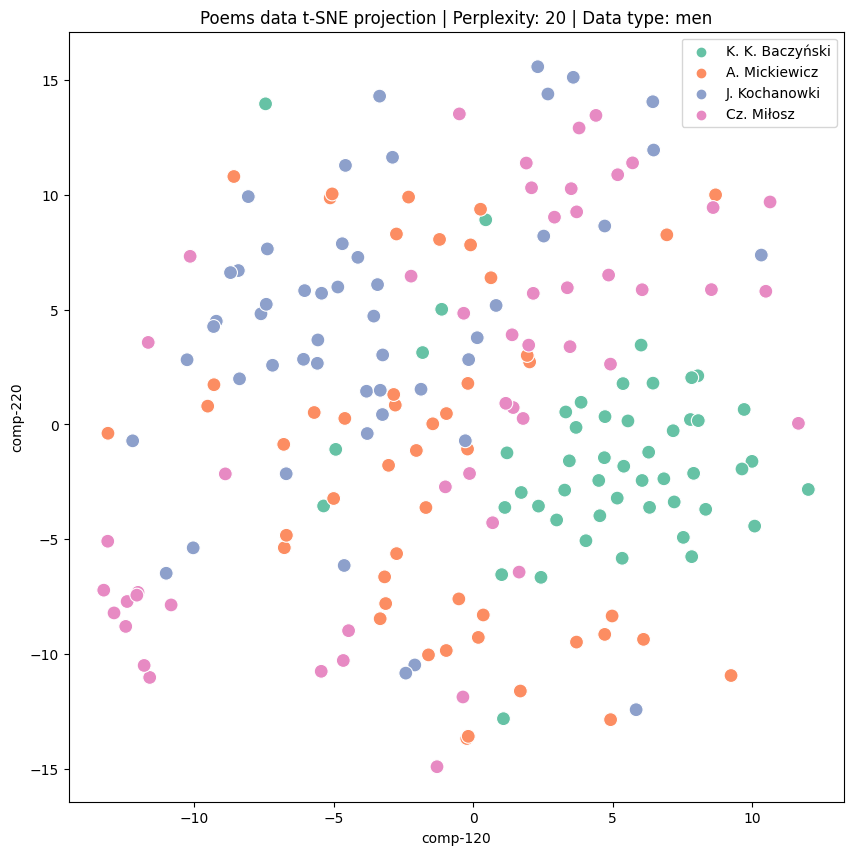

In [ ]:
df_tsne = pd.DataFrame()
df_tsne["y"] = df_men['Author-short']
data_type = 'men'
num_classes = len(classes)

perps = [20]

for perp in perps:

  plt.figure(figsize = (10,10))
  z = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=perp).fit_transform(X_norm, y)

  df_tsne["comp-1{}".format(perp)] = z[:,0]
  df_tsne["comp-2{}".format(perp)] = z[:,1]

  sns.scatterplot(x="comp-1{}".format(perp), y="comp-2{}".format(perp), hue=df_tsne.y.tolist(),
                palette=sns.color_palette("Set2", num_classes),
                data=df_tsne, s=100).set(title="Poems data t-SNE projection | Perplexity: {} | Data type: {}".format(perp, data_type))

  plt.savefig('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))
  files.download('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))

In [ ]:
distance_euclidean_X_normalized = np.zeros((X_norm.shape[0], X_norm.shape[0]))
distance_cosinus_X_normalized = np.zeros((X_norm.shape[0], X_norm.shape[0]))

for i in range(0,distance_euclidean_X_normalized.shape[0]):
  x_normalized_i = X_norm[i,:]
  for j in range(0,distance_euclidean_X_normalized.shape[0]):
    x_normalized_j = X_norm[j,:]
    distance_euclidean_X_normalized[i,j] = np.sqrt(np.sum( np.abs(x_normalized_i - x_normalized_j)**2))
    distance_cosinus_X_normalized[i,j] = np.dot(x_normalized_i, x_normalized_j)/1024


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

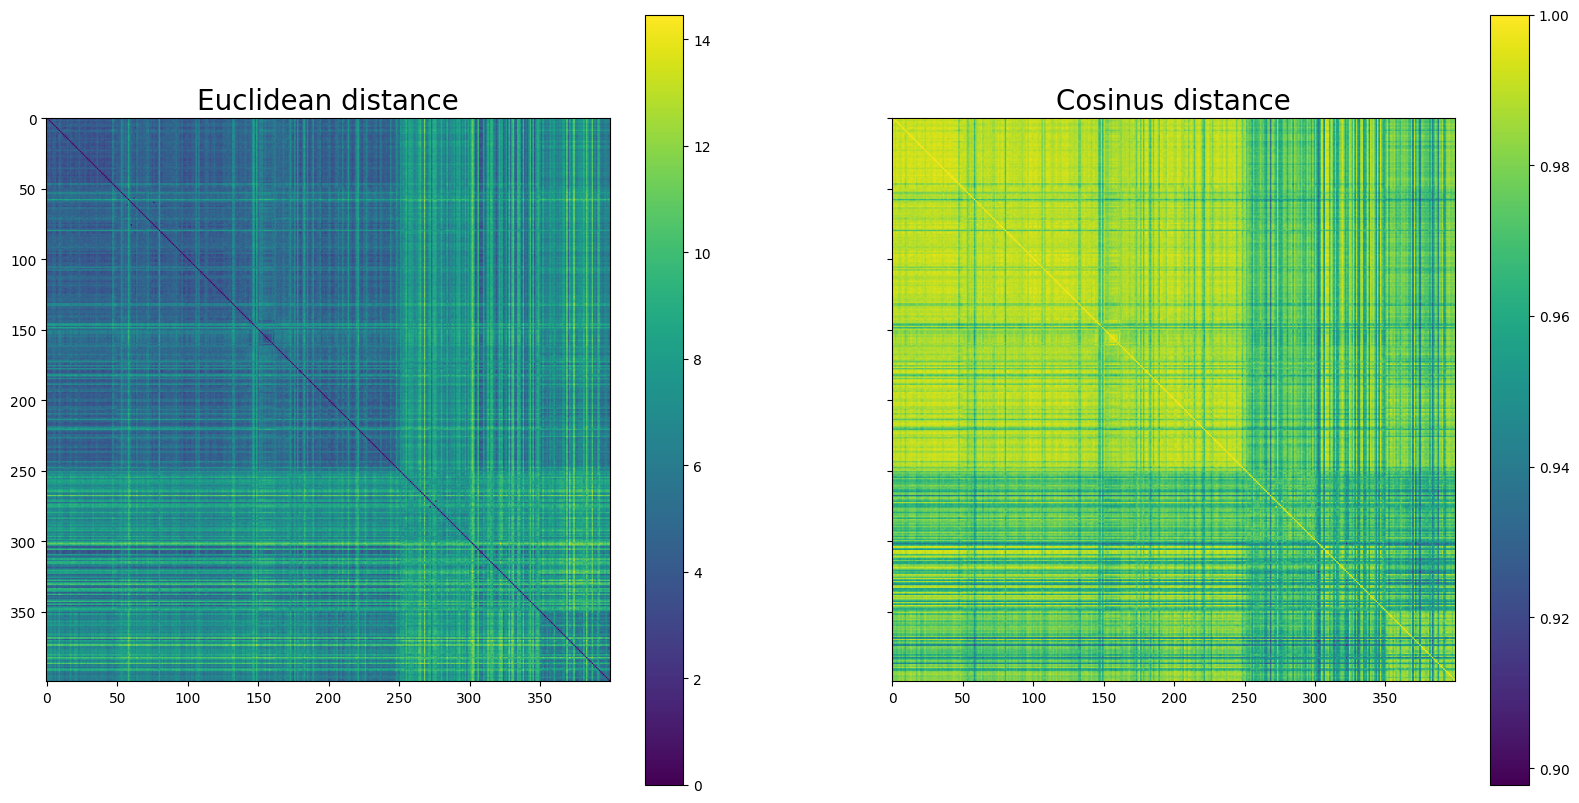

In [ ]:
distances = {"Euclidean distance":distance_euclidean_X_normalized, "Cosinus distance":distance_cosinus_X_normalized}
data_type = "all"
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey='row')
im = ax[0].imshow(distance_euclidean_X_normalized)
ax[0].set_title('Euclidean distance', fontsize=20)
im2 = ax[1].imshow(distance_cosinus_X_normalized)
ax[1].set_title('Cosinus distance', fontsize=20)
fig.colorbar(im, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

fig.savefig('/content/figs/euclidean_and_cosinus.png')
files.download('/content/figs/euclidean_and_cosinus.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

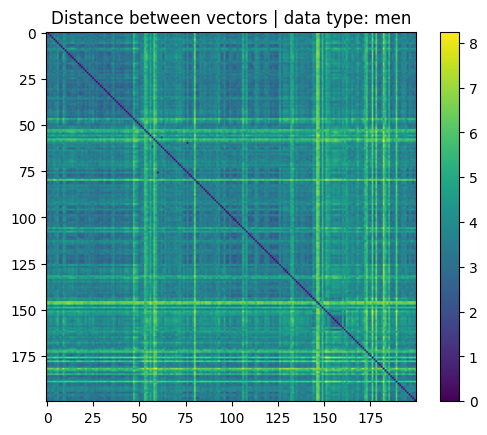

In [ ]:
M_men = np.zeros((200,200))

for i in range(0,200):
  x_i = embedded_men['Herbert_embedding'][i]
  for j in range(0,200):
    x_j = embedded_men['Herbert_embedding'][j]

    #scalar_product = np.dot(x_i, x_j)
    #M[i,j] = scalar_product
    M_men[i,j] = np.sqrt(np.sum( np.abs(x_i - x_j)**2))
plt.imshow(M_men)
plt.colorbar()
plt.title('Distance between vectors | data type: men')


plt.savefig('/content/odległość_wektorów_po_ombeddingu_men.png')
files.download('/content/odległość_wektorów_po_ombeddingu_men.png')

In [ ]:
df_tsne = pd.DataFrame()
df_tsne["y"] = df_women['Author-short']
data_type = 'men'
num_classes = len(classes)

perps = [5, 10, 15, 20, 25, 30, 35, 40]

for perp in perps:

  plt.figure(figsize = (10,10))
  z = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=perp).fit_transform(X_norm, y)

  df_tsne["comp-1{}".format(perp)] = z[:,0]
  df_tsne["comp-2{}".format(perp)] = z[:,1]

  sns.scatterplot(x="comp-1{}".format(perp), y="comp-2{}".format(perp), hue=df_tsne.y.tolist(),
                palette=sns.color_palette("Set2", num_classes),
                data=df_tsne, s=100).set(title="Poems data t-SNE projection | perplexity: {} | data_type: {}".format(perp, data_type))

  plt.savefig('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))
  files.download('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))